## KDEs for time series

To illustrate the `kdetools` API, fit a KDE time series model to some example data from `statsmodels` and simulate from it.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
# Extended KDE functions including conditional sampling
import kdetools as kt

#### Univariate example

Load sunspot data:

In [4]:
sspot = sm.datasets.sunspots.load_pandas().data.astype(int).set_index('YEAR')
print(sspot.shape)
sspot.head(3)

(309, 1)


,SUNACTIVITY
YEAR,
1700,5
1701,11
1702,16


Model the joint distribution of lag-0, lag-1 and lag-2 values, so an 'order 2' model.

In [5]:
p = 2
X = pd.concat([sspot[['SUNACTIVITY']].shift(i).add_suffix(f'-{i}') for i in range(p, -1, -1)], axis=1).dropna()
print(X.shape)
X.head()

(307, 3)


,SUNACTIVITY-2,SUNACTIVITY-1,SUNACTIVITY-0
YEAR,,,
1702,5.0,11.0,16
1703,11.0,16.0,23
1704,16.0,23.0,36
1705,23.0,36.0,58
1706,36.0,58.0,29


Note also that since this is a count model, need to do a transformation to prevent modelling negative numbers.

In [6]:
X = np.sqrt(X)

Visualise dependence structure:

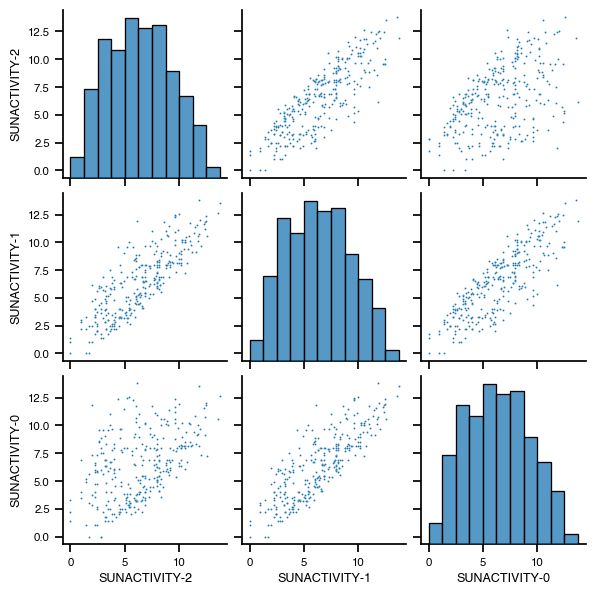

In [7]:
sns.set_context('notebook', font_scale=0.75)
sns.pairplot(X, height=2, plot_kws={'s': 2});

#### Fit KDE model to data and simulate

Fit a 3-dimensional KDE, noting that the base `gaussian_kde` class expects data with features as rows and instances as columns, hence the transpose:

In [8]:
kde = kt.gaussian_kde(X.T)
kde.factor

0.4412599564492907

Set the bandwidth using new cross-validation method:

In [9]:
kde.set_bandwidth(bw_method='cv', bw_type='covariance')
kde.factor

array([0.37291134])

Define an array to store the results and populate with the initial values from the training data

In [10]:
# Data index at which to start simulating
ix0 = 200

# Ensemble members M and time steps N to simulate
M, N = 1000, sspot.shape[0] - ix0

# Create array to store simulations and populate first two time steps
sims = np.zeros((M, N))
sims[:,:p] = X.values[ix0,:2]

Run time-stepping loop:

In [11]:
np.random.seed(0)

for i in tqdm(range(p, N)):
    x_cond = np.vstack([sims[:,i-2], sims[:,i-1]]).T
    sims[:,i] = kde.conditional_resample(1, x_cond=x_cond, dims_cond=[0, 1])[:,0,0]

# Reverse the transformation
sims = sims**2

# Calculate mean of all simulations and 5th and 95th percentiles
sims_q05 = pd.DataFrame(np.quantile(sims, 0.05, axis=0), columns=sspot.columns).add_suffix('_5th')
sims_mean = pd.DataFrame(sims.mean(axis=0), columns=sspot.columns).add_suffix('_mean')
sims_q95 = pd.DataFrame(np.quantile(sims, 0.95, axis=0), columns=sspot.columns).add_suffix('_95th')

  0%|          | 0/107 [00:00<?, ?it/s]

##### Compare summary statistics

In [12]:
pd.DataFrame([sspot['SUNACTIVITY'].describe().rename('orig'), 
              pd.Series(sims.ravel(), name='sim').describe()])

,count,mean,std,min,25%,50%,75%,max
orig,309.0,49.368932,40.405571,0.000000e+00,16.000000,40.000000,69.000000,190.000000
sim,109000.0,49.848923,43.739099,7.185786e-08,14.198722,38.607959,73.923743,300.291819


##### Visualise the simulated results

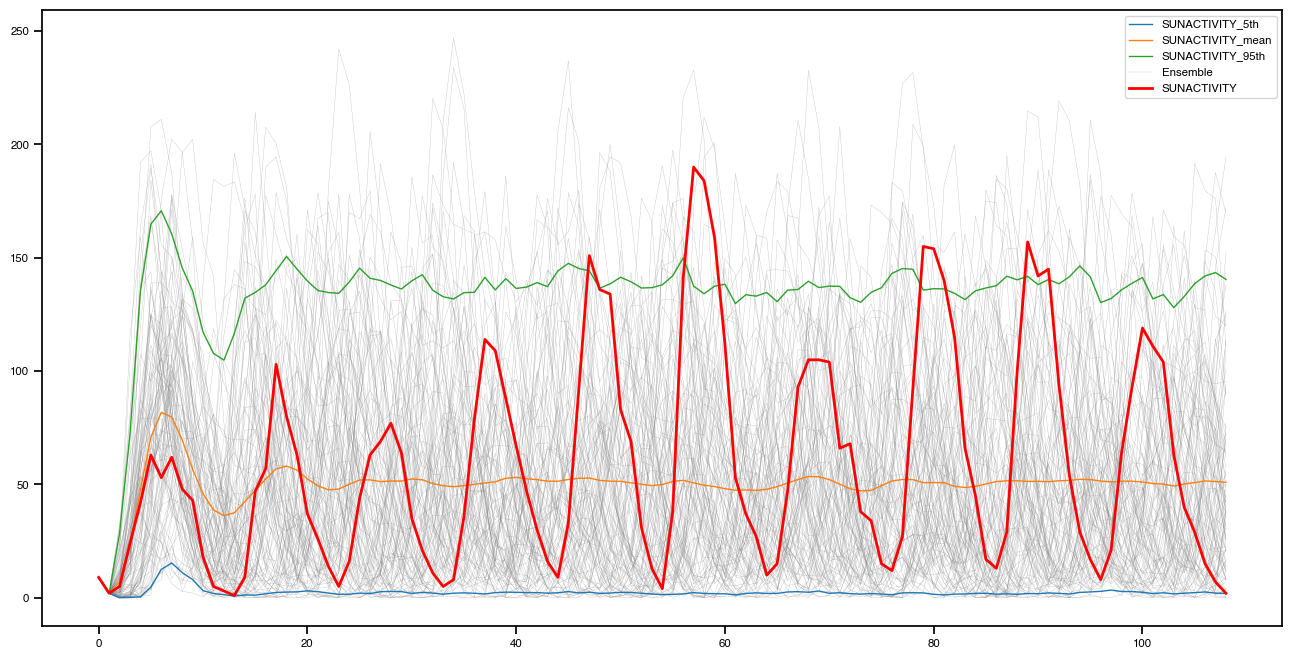

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

sims_q05.plot(ax=ax, ls='-', lw=1, label='5th percentile')
sims_mean.plot(ax=ax, ls='-', lw=1, label='mean')
sims_q95.plot(ax=ax, ls='-', lw=1, label='95th percentile')

for i in range(min(M, 100)):
    ax.plot(sims[i], color='0.5', lw=0.25, zorder=-3, alpha=0.5, label='Ensemble' if i==0 else None)

sspot.iloc[ix0:].reset_index(drop=True).plot(ax=ax, lw=2, color='r', label='Actual data')
ax.legend();

##### Compare full and partial autocorrelations of input data

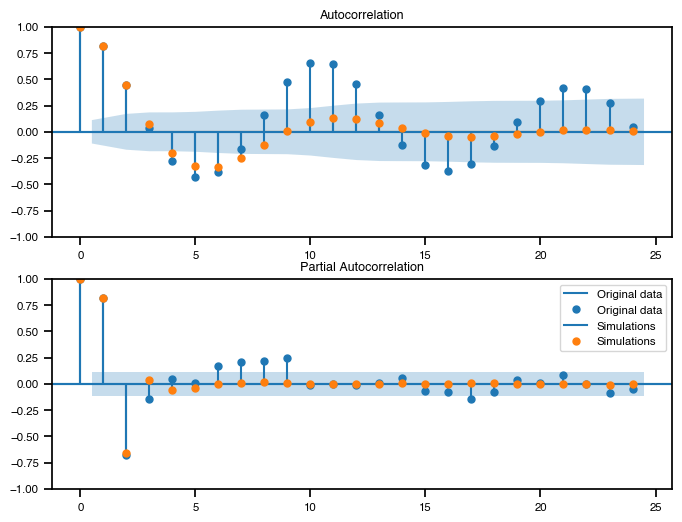

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
plot_acf(sspot, lags=24, ax=ax1, label='Original data')
plot_acf(sims.ravel(), lags=24, ax=ax1, label='Simulations')
plot_pacf(sspot, lags=24, ax=ax2, label='Original data')
plot_pacf(sims.ravel(), lags=24, ax=ax2, label='Simulations')
ax2.legend();

##### Compare ECDFs

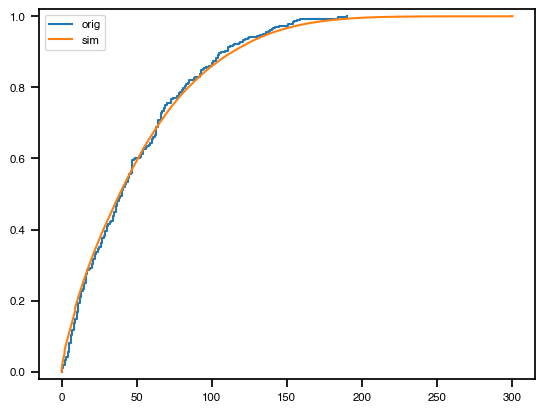

In [15]:
fig, ax = plt.subplots()
ax.ecdf(sspot['SUNACTIVITY'], label='orig')
ax.ecdf(sims.ravel(), label='sim')
ax.set_ylim((-0.02, 1.02)); ax.legend();